# Tarea 3

El siguiente código se preparó para resolver nuestra tercera tarea del curso, en donde prepocesaremos la data entregada, para posteriormente procesarla a través de tres modelos, como son Regresión Logística, Árbol de Decisión y Redes Neuronales.

Elaborado por Maximiliano Díaz, Fernando Gallardo, Josué Quilapan.

# 1.- Carga de Datos

In [5]:
import warnings
warnings.filterwarnings("ignore")
import time
start_time = time.time()
import pandas as pd
import numpy as np

# Leyendo los datos de un archivo csv:
data = pd.read_csv('X_y_train.csv')
test = pd.read_csv('X_test.csv')
print('Cantidad de Datos (N)= ' + str(len(data)))
print('Cantidad de Variables (M) = ' + str(len(data.columns)))

Cantidad de Datos (N)= 36168
Cantidad de Variables (M) = 18


### Borrar Id.

El primer paso de preprocesamiento, será borrar la variable id, ya que no aporta información relevante.

In [6]:
data_1 = data.drop('Id', axis=1)
test_1 = test.drop('Id', axis=1)
data_train_total = data.drop('Id', axis=1)

### Transformación de variables binarias.
Se transforman las variables binarias que estan en texto a valores 1 y 0.

In [7]:
#Varible default
Default = {'yes': 1,'no': 0}
data_1.default = [Default[i] for i in data_1.default]
test_1.default = [Default[i] for i in test_1.default]
data_train_total.default = [Default[i] for i in data_train_total.default]

#Varible loan
Loan = {'yes': 1,'no': 0}
data_1.loan = [Loan[i] for i in data_1.loan]
test_1.loan = [Loan[i] for i in test_1.loan]
data_train_total.loan = [Loan[i] for i in data_train_total.loan]

#Varible housing
Housing = {'yes': 1,'no': 0}
data_1.housing = [Housing[i] for i in data_1.housing]
test_1.housing = [Housing[i] for i in test_1.housing]
data_train_total.housing = [Housing[i] for i in data_train_total.housing]

### Transformación de variables categóricas.
Las variables categoricas son convertidas a dummies, de esta forma no ponderamos una categoría por sobre otra.

In [8]:
data_2 = data_1.copy()
data_2 = pd.get_dummies(data_2, columns=['job','marital','education','contact','month','poutcome'])
test_2 = test_1.copy()
test_2 = pd.get_dummies(test_2, columns=['job','marital','education','contact','month','poutcome'])
data_train_total_2 = data_train_total.copy()
data_train_total_2 = pd.get_dummies(data_train_total_2, columns=['job','marital','education','contact','month','poutcome'])

### Transformación de la variable $y$.
Se tranforma la variable $y$ a dummie, en donde $yes$ toma el valor de 1 y $no$ toma el valor 0.

In [9]:
data_2 = pd.get_dummies(data_2, columns=['y'], drop_first = True)
data_train_total_2 = pd.get_dummies(data_train_total_2, columns=['y'], drop_first = True)

### División base Data.
Se divide la base data en train y test, otorgando un 80% a train y un 20% a test, tal como se indica en el enunciado.

In [10]:
from sklearn.model_selection import train_test_split

variables = data_2.columns[:-1]
target = data_2.columns[-1]
X_train, X_test, y_train, y_test = train_test_split(data_2[variables], data_2[target], test_size=0.2, 
                                                                           stratify = data_2[target], random_state=0)

### División base Data total.
Se separan las variables dependiente e independiente de la base data total.

In [11]:
X_train_total = data_train_total_2[data_train_total_2.columns[:-1]]
y_train_total = data_train_total_2[data_train_total_2.columns[-1]]

### Cálculo de AUC de cada variable.
Se calcula el auc de cada variable, de esta forma poder obtener cierto ranking sobre las variables que se crearon.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn import tree
clf = tree.DecisionTreeClassifier()

auc_variables = pd.DataFrame(columns=['variable', 'auc'])

for var in variables:
    x = X_train[var]
    scores = cross_val_score(clf, x.values.reshape(-1,1), y_train, cv=3, scoring = 'roc_auc')
    auc_variables.loc[len(auc_variables)] = [var, np.mean(scores)]
auc_variables = auc_variables.sort_values(by=['auc'], ascending=False)
auc_variables.head()

,variable,auc
6,duration,0.701650
31,contact_unknown,0.604549
3,housing,0.604079
29,contact_cellular,0.601980
9,previous,0.601043


### Definición de variables relevantes.
Se definen las variables relevantes, aquellas que cumplan el criterio de AUC sea mayor a 0.5, siendo considerado este un criterio aceptable por nuestro grupo.

In [13]:
variables_pred = auc_variables.loc[auc_variables['auc']>0.5, 'variable']

### Normalización de la data.
Se procede a normalizar las distintas datas que tenemos, entre ellas la data que generamos a partir del split, y también, la base train total.

In [14]:
from sklearn import preprocessing
norm_mean = preprocessing.StandardScaler().fit(X_train[variables_pred])
X_train_norm = pd.DataFrame(norm_mean.transform(X_train[variables_pred]), 
                            columns = X_train[variables_pred].columns)
X_test_norm = pd.DataFrame(norm_mean.transform(X_test[variables_pred]), columns=X_test[variables_pred].columns)

norm_mean_train_total = preprocessing.StandardScaler().fit(X_train_total[variables_pred])
X_train_total_norm = pd.DataFrame(norm_mean_train_total.transform(X_train_total[variables_pred]), 
                                  columns = X_train_total[variables_pred].columns)

# 2.- Regresión Logística
En este apartado, vamos a optimizar dos parámetros de la regresión logística, tales como "C" y el "Penalty". Una vez encontrados estos valores óptimos, procedemos a entrenar el modelo con los mejores parámetros.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

rl = LogisticRegression(random_state=0, class_weight='balanced')
parameters = {'C':[1, 0.1, 0.01], 'penalty': ['l1','l2']}
clf = GridSearchCV(rl, parameters, scoring = 'roc_auc', cv = 2)
clf.fit(X_train_norm, y_train)
print('C escogido: ' +str(clf.best_params_['C']))
print('Penalty escogida: ' +str(clf.best_params_['penalty']))

C escogido: 0.01
Penalty escogida: l1


In [16]:
rl_best = LogisticRegression(random_state=0, C= clf.best_params_['C'], penalty = clf.best_params_['penalty'], class_weight='balanced')
rl_best.fit(X_train_norm, y_train)
y_pred = rl_best.predict(X_train_norm)
y_pred_proba = rl_best.predict_proba(X_train_norm)[:,1]

In [17]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

measures_train = precision_recall_fscore_support(y_train, y_pred, average = 'binary')
auc_train = roc_auc_score(y_train, y_pred_proba)
accuracy_train = np.sum(y_train==y_pred) / len(X_train)

In [18]:
resultados = pd.DataFrame()
resultados['Metric'] = ['Precision', 'Recall', 'F-Score', 'AUC', 'Accuracy']
resultados['LR_Train'] = [measures_train[0],measures_train[1],measures_train[2],auc_train,accuracy_train]

In [15]:
y_pred_test_rl = rl_best.predict(X_test_norm)
y_pred_proba_test_rl = rl_best.predict_proba(X_test_norm)[:,1]

measures_test = precision_recall_fscore_support(y_test, y_pred_test_rl, average = 'binary')
auc_test = roc_auc_score(y_test, y_pred_proba_test_rl)
accuracy_test = np.sum(y_test==y_pred_test_rl) / len(X_test)

resultados['LR_Test'] = [measures_test[0],measures_test[1],measures_test[2],auc_test,accuracy_test]
print("--- %s seconds ---" % (time.time() - start_time))
resultados

--- 35.381935358047485 seconds ---


,Metric,LR_Train,LR_Test
0,Precision,0.413726,0.429102
1,Recall,0.813885,0.819149
2,F-Score,0.548586,0.563186
3,AUC,0.910104,0.915491
4,Accuracy,0.843299,0.851396


# 3.- Árbol de decisión
Para abordar este modelo, vamos a proceder a optimizar tres hiperparámetros, tales como la proporción que tendrán las hojas finales, la profundidad que tendrá y el criterio que se va a usar.
Con los mejores parámetros, procedemos a entrenar este modelo.

In [16]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0, class_weight='balanced')
parameters = {'min_samples_leaf':[0.01, 0.05, 0.1, 0.15, 0.2],
             'max_depth': [5,10,15,20,30],
             "criterion": ["gini", "entropy"]}
clf = GridSearchCV(dt, parameters, scoring = 'roc_auc', cv = 5)
clf.fit(X_train[variables_pred], y_train)
print('Proporción escogida en hojas finales: ' +str(clf.best_params_['min_samples_leaf']*100))
print('Profundidad escogida: ' +str(clf.best_params_['max_depth']))
print('Criterio : ' +str(clf.best_params_['criterion']))

Proporción escogida en hojas finales: 1.0
Profundidad escogida: 15
Criterio : entropy


In [17]:
dt_best = DecisionTreeClassifier(random_state=0, max_depth = clf.best_params_['max_depth'], class_weight='balanced',
             min_samples_leaf = clf.best_params_['min_samples_leaf'] , criterion= clf.best_params_['criterion'])
dt_best.fit(X_train[variables_pred], y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=15, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.01, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [18]:
y_pred = dt_best.predict(X_train[variables_pred])
y_pred_proba = dt_best.predict_proba(X_train[variables_pred])[:,1]
measures_train = precision_recall_fscore_support(y_train, y_pred, average = 'binary')
auc_train = roc_auc_score(y_train, y_pred_proba)
accuracy_train = np.sum(y_train==y_pred) / len(X_train)
resultados['DTree_Train'] = [measures_train[0],measures_train[1],measures_train[2],auc_train,accuracy_train]

In [19]:
y_pred_test_dt  = dt_best.predict(X_test[variables_pred])
y_pred_proba_test_dt = dt_best.predict_proba(X_test[variables_pred])[:,1]

measures_test = precision_recall_fscore_support(y_test, y_pred_test_dt, average = 'binary')
auc_test = roc_auc_score(y_test, y_pred_proba_test_dt)
accuracy_test = np.sum(y_test==y_pred_test_dt) / len(X_test)
resultados['DTree_Test'] = [measures_test[0],measures_test[1],measures_test[2],auc_test,accuracy_test]
print("--- %s seconds ---" % (time.time() - start_time))
resultados

--- 80.00123429298401 seconds ---


,Metric,LR_Train,LR_Test,DTree_Train,DTree_Test
0,Precision,0.413726,0.429102,0.342844,0.345936
1,Recall,0.813885,0.819149,0.873264,0.865248
2,F-Score,0.548586,0.563186,0.492379,0.494261
3,AUC,0.910104,0.915491,0.905731,0.901350
4,Accuracy,0.843299,0.851396,0.789348,0.792922


# 4.- Red Neuronal
En primer lugar, vamos a definir la red neuronal.

In [11]:
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.initializers import he_normal 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
def Red_Neuronal(optimizer = 'Adam', activation='elu' ):

    keras.backend.clear_session()
    nn1 = Sequential()
    
    #Capa 1:
    nn1.add(Dense(len(variables_pred), input_dim=len(variables_pred), kernel_initializer=he_normal()))
    nn1.add(Activation(activation))
    nn1.add(Dropout(0.3))
    #Capa 2:
    nn1.add(Dense(len(variables_pred), kernel_initializer=he_normal()))
    nn1.add(Activation(activation))
    nn1.add(Dropout(0.1))
    
    #Capa 3:
    nn1.add(Dense(len(variables_pred), kernel_initializer=he_normal()))
    nn1.add(Activation(activation))
    nn1.add(Dropout(0.1))

    #Capa 4 - Final:
    nn1.add(Dense(1))
    nn1.add(Activation('sigmoid'))
    #Se compila la red neuronal
    nn1.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=["accuracy"])
    return nn1   

Using TensorFlow backend.


#### Se crea el modelo de red neuronal

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
nn1 = KerasClassifier(build_fn=Red_Neuronal)

#### Se determinan los hiperparámetros para la red neuronal

In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
stopped = EarlyStopping(monitor='val_loss', verbose=1, patience=75,min_delta=1e-7, mode='min', baseline=0.18,restore_best_weights=False )
best_model = ModelCheckpoint(filepath='Best_nn.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [16]:
from sklearn.model_selection import GridSearchCV
parameter = {'optimizer' : ['Nadam', 'Adam'  ],
            'activation' : ['relu', 'elu'],
            'epochs':[1]}

clf1 =  GridSearchCV(estimator=nn1, param_grid=parameter, cv=2)
NN_2=clf1.fit(X_train_norm, y_train, validation_data=(X_test_norm,y_test),
                    batch_size=32, class_weight=class_weights, verbose=1, callbacks=[stopped,best_model])

print('Optimizer escogido: ' +str(NN_2.best_params_['optimizer']))
print('Función de activación escogida: ' +str(NN_2.best_params_['activation']))
print('Epochs escogidos: ' +str(NN_2.best_params_['epochs']))

Train on 14467 samples, validate on 7234 samples
Epoch 1/1
14467/14467 [==============================] - 1s 71us/step - loss: 0.3426 - acc: 0.8696 - val_loss: 0.2328 - val_acc: 0.8976

Epoch 00001: val_loss did not improve from 0.21551
14467/14467 [==============================] - 0s 14us/step
Train on 14467 samples, validate on 7234 samples
Epoch 1/1
14467/14467 [==============================] - 1s 74us/step - loss: 0.3122 - acc: 0.8833 - val_loss: 0.2285 - val_acc: 0.8980

Epoch 00001: val_loss did not improve from 0.21551
14467/14467 [==============================] - 0s 14us/step
Train on 14467 samples, validate on 7234 samples
Epoch 1/1
14467/14467 [==============================] - 1s 72us/step - loss: 0.3330 - acc: 0.8785 - val_loss: 0.2390 - val_acc: 0.8911

Epoch 00001: val_loss did not improve from 0.21551
14467/14467 [==============================] - 0s 15us/step
Train on 14467 samples, validate on 7234 samples
Epoch 1/1
14467/14467 [==============================] - 1s 

In [17]:
from keras.models import load_model
NN_3 = load_model('Best_nn.hdf5')
print('Optimizer escogido: ' +str(NN_2.best_params_['optimizer']))
print('Función de activación escogida: ' +str(NN_2.best_params_['activation']))
print('Epochs escogidos: ' +str(NN_2.best_params_['epochs']))
NN_3.summary()

Optimizer escogido: Nadam
Función de activación escogida: elu
Epochs escogidos: 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 45)                2070      
_________________________________________________________________
activation_1 (Activation)    (None, 45)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 45)                2070      
_________________________________________________________________
activation_2 (Activation)    (None, 45)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 45)                0         
____________________________________________________________

In [32]:
y_pred_proba = NN_3.predict(X_train_norm)
y_pred = np.zeros((len(y_pred_proba),1))
y_pred[y_pred_proba>0.2] = 1 # No predice nada con grandes probabilidades
y_pred = y_pred.reshape((-1,))

measures_train = precision_recall_fscore_support(y_train, y_pred, average = 'binary')
auc_train = roc_auc_score(y_train, y_pred_proba)
accuracy_train = np.sum(y_train==y_pred) / len(X_train)
resultados['NN_Train'] = [measures_train[0],measures_train[1],measures_train[2],auc_train,accuracy_train]

#### Se testea al modelo.

In [35]:
y_pred_proba_test_nn = NN_3.predict(X_test_norm)
y_pred_test_nn = np.zeros((len(y_pred_proba_test_nn),1))
y_pred_test_nn[y_pred_proba_test_nn>0.2] = 1 # No predice nada con grandes probabilidades
y_pred_test_nn = y_pred_test_nn.reshape((-1,))

measures_test = precision_recall_fscore_support(y_test, y_pred_test_nn, average = 'binary')
auc_test = roc_auc_score(y_test, y_pred_proba_test_nn)
accuracy_test = np.sum(y_test==y_pred_test_nn) / len(X_test)
resultados['NN_Test'] = [measures_test[0],measures_test[1],measures_test[2],auc_test,accuracy_test]
print("--- %s seconds ---" % (time.time() - start_time))
resultados

--- 2771.3521065711975 seconds ---


,Metric,LR_Train,LR_Test,DTree_Train,DTree_Test,NN_Train,NN_Test
0,Precision,0.413726,0.429102,0.342844,0.345936,0.556761,0.559910
1,Recall,0.813885,0.819149,0.873264,0.865248,0.879468,0.878251
2,F-Score,0.548586,0.563186,0.492379,0.494261,0.681860,0.683847
3,AUC,0.910104,0.915491,0.905731,0.901350,0.959163,0.960653
4,Accuracy,0.843299,0.851396,0.789348,0.792922,0.903988,0.905032


# 5.- Comparación de los modelos.
Para poder comparar los tres modelos presentados, vamos a graficar la curva ROC de los modelos de forma conjunta, expresando en la esquina inferior derecha, el valor obtenido bajo la curva.

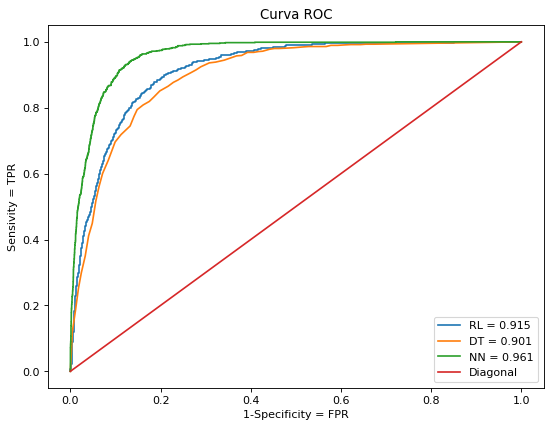

In [37]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn import metrics

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

fpr_rl, tpr_rl, t_rl = metrics.roc_curve(y_test, y_pred_proba_test_rl)
plt.plot(fpr_rl,tpr_rl, label=("RL = %.3f" %resultados.iloc[3,2]))

fpr_dt, tpr_dt, t_dt = metrics.roc_curve(y_test, y_pred_proba_test_dt)
plt.plot(fpr_dt,tpr_dt, label=("DT = %.3f" %resultados.iloc[3,4]))

fpr_nn, tpr_nn, t_nn = metrics.roc_curve(y_test, y_pred_proba_test_nn)
plt.plot(fpr_nn,tpr_nn, label=("NN = %.3f" %resultados.iloc[3,6]))

x = np.linspace(0, 1, 100)
plt.plot(x,x, label=("Diagonal"))

plt.xlabel('1-Specificity = FPR')
plt.ylabel('Sensivity = TPR')
plt.title('Curva ROC')

plt.legend(loc=4)
plt.show()

### Elección del mejor modelo.
Para poder decantarnos por un modelo, vamos a escoger aquel que presente el mejor AUC, siendo el mejor, la Red Neuronal.

# 6.- Entrenamiento final y predicción.
Antes de poder predecir sobre la base test, necesitamos entrenar el mejor modelo en la base data total.

In [38]:
NN_3.fit(X_train_total_norm, y_train_total,
                    batch_size=32, class_weight=class_weights, epochs=NN_2.best_params_['epochs'],  verbose=1)

Epoch 1/100
36168/36168 [==============================] - 3s 87us/step - loss: 0.1807 - acc: 0.9181
Epoch 2/100
36168/36168 [==============================] - 3s 91us/step - loss: 0.1810 - acc: 0.9181
Epoch 3/100
36168/36168 [==============================] - 3s 87us/step - loss: 0.1808 - acc: 0.9193
Epoch 4/100
36168/36168 [==============================] - 3s 89us/step - loss: 0.1818 - acc: 0.9181
Epoch 5/100
36168/36168 [==============================] - 3s 93us/step - loss: 0.1796 - acc: 0.9199
Epoch 6/100
36168/36168 [==============================] - 3s 92us/step - loss: 0.1810 - acc: 0.9176
Epoch 7/100
36168/36168 [==============================] - 3s 86us/step - loss: 0.1801 - acc: 0.9180
Epoch 8/100
36168/36168 [==============================] - 3s 85us/step - loss: 0.1803 - acc: 0.9189
Epoch 9/100
36168/36168 [==============================] - 3s 95us/step - loss: 0.1808 - acc: 0.9165
Epoch 10/100
36168/36168 [==============================] - 3s 89us/step - loss: 0.1796 - a

### Predicción.
Como ya entrenamos el mejor modelo, procedemos a predecir sobre nuestra base test.

In [39]:
test_2_norm = pd.DataFrame(norm_mean_train_total.transform(test_2[variables_pred]), 
                            columns = test_2[variables_pred].columns)

In [40]:
y_clientes = test.iloc[:,0]
predictions = NN_3.predict(test_2_norm[variables_pred])

### Creación del archivo CSV.
Se crea un archivo csv con la prediccion para cada ID.

In [41]:
columns = ['Prediccion']
y_clientes = pd.DataFrame(y_clientes)
df_predict = pd.DataFrame(predictions, columns=columns)
prediccion= pd.concat([y_clientes, df_predict], axis=1,)
prediccion
prediccion.to_csv('Diaz_Gallardo_Quilapan.csv', index=False)